# Comparison

## Complete ML workflow

1. Define the steps and its environments.
2. Run the workflow
3. Deploy a ML model 
4. Scale the ML model

# MLflow

Goal: Platform for managing the end-to-end machine learning lifecycle using Tracking, Projects, Models modules.

Pros
- Lightweight library (pip install mlflow).
- Allows collaborating among teams because of tracking metrics, artifacts, models, etc.
- Version control.

Cons
- Difficult to define workflows. https://databricks.com/product/managed-mlflow
- No parallel, nested workflows executions.
- No post-modeling checking.

## Example

- Multistep example, it consists of 4 steps in sequential order in the same environment (conda or docker environment), therefore, every step share the same libraries.

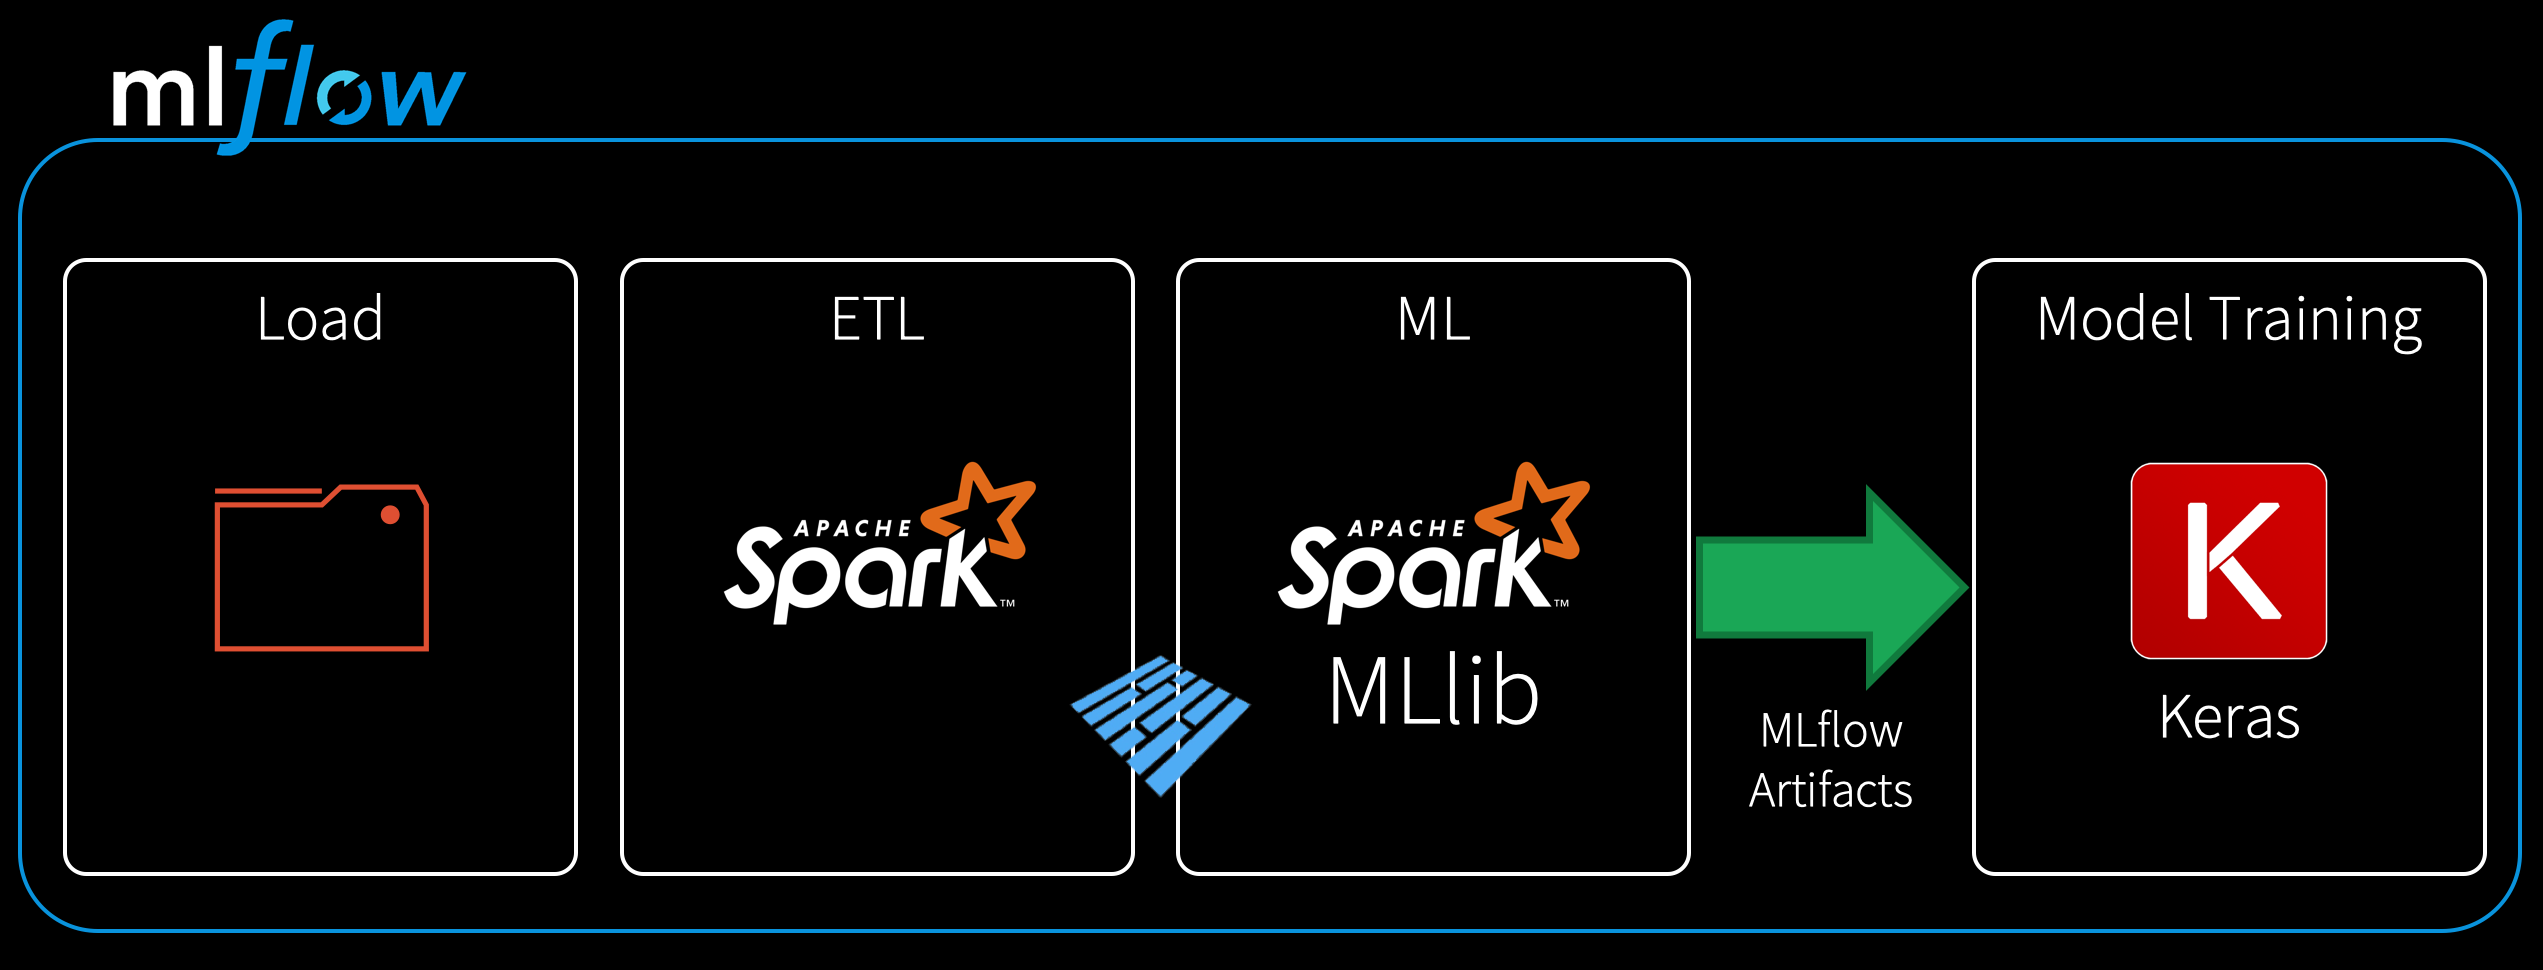

In [6]:
from IPython.display import Image
Image("mlflow_workflow.png", width=600, height=600)

```
name: multistep_example

conda_env: conda.yaml

entry_points:
  load_raw_data:
    command: "python load_raw_data.py"

  etl_data:
    parameters:
      ratings_csv: path
      max_row_limit: {type: int, default: 100000}
    command: "python etl_data.py --ratings-csv {ratings_csv} --max-row-limit {max_row_limit}"

  als:
    parameters:
      ratings_data: path
      max_iter: {type: int, default: 10}
      reg_param: {type: float, default: 0.1}
      rank: {type: int, default: 12}
    command: "python als.py --ratings-data {ratings_data} --max-iter {max_iter} --reg-param {reg_param} --rank {rank}"

  train_keras:
    parameters:
      ratings_data: path
      als_model_uri: string
      hidden_units: {type: int, default: 20}
    command: "python train_keras.py --ratings-data {ratings_data} --als-model-uri {als_model_uri} --hidden-units {hidden_units}"

  main:
    parameters:
      als_max_iter: {type: int, default: 10}
      keras_hidden_units: {type: int, default: 20}
      max_row_limit: {type: int, default: 100000}
    command: "python main.py --als-max-iter {als_max_iter} --keras-hidden-units {keras_hidden_units}
                             --max-row-limit {max_row_limit}"
                             
```

# Kubeflow / Airflow

Goal: Dedicated to making deployments of machine learning (ML) workflows on Kubernetes simple, portable and scalable


Pros
- Scheduling incluided (with kubernetes).
- Nested and parallel workflows execution.
- Version control.

Cons
- Hard installation, prototyping.
- Not post-modeling checking.
- Not orchestator-agnostic (only kubernetes).

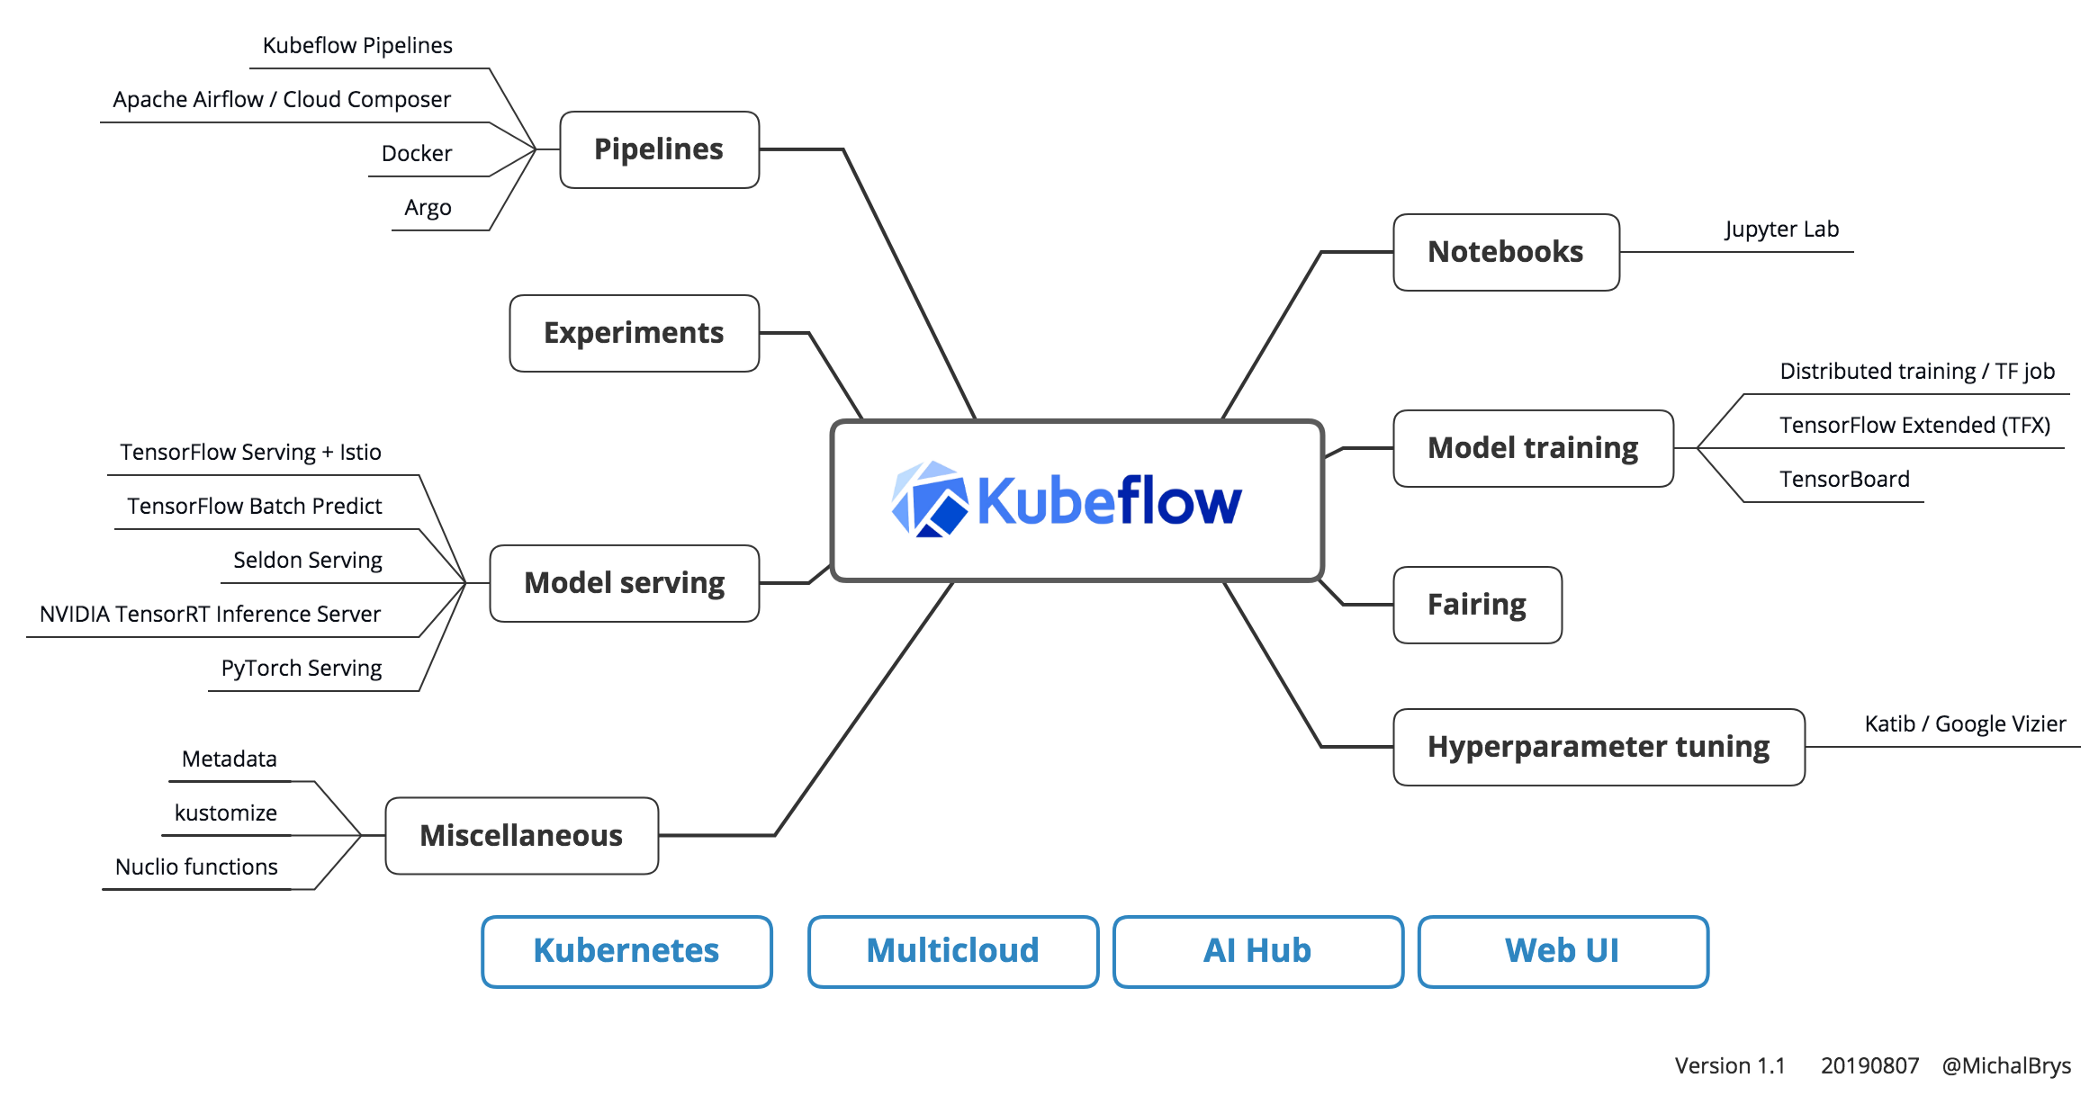

In [7]:
from IPython.display import Image
Image("kubeflow_workflow.png", width=600, height=600)

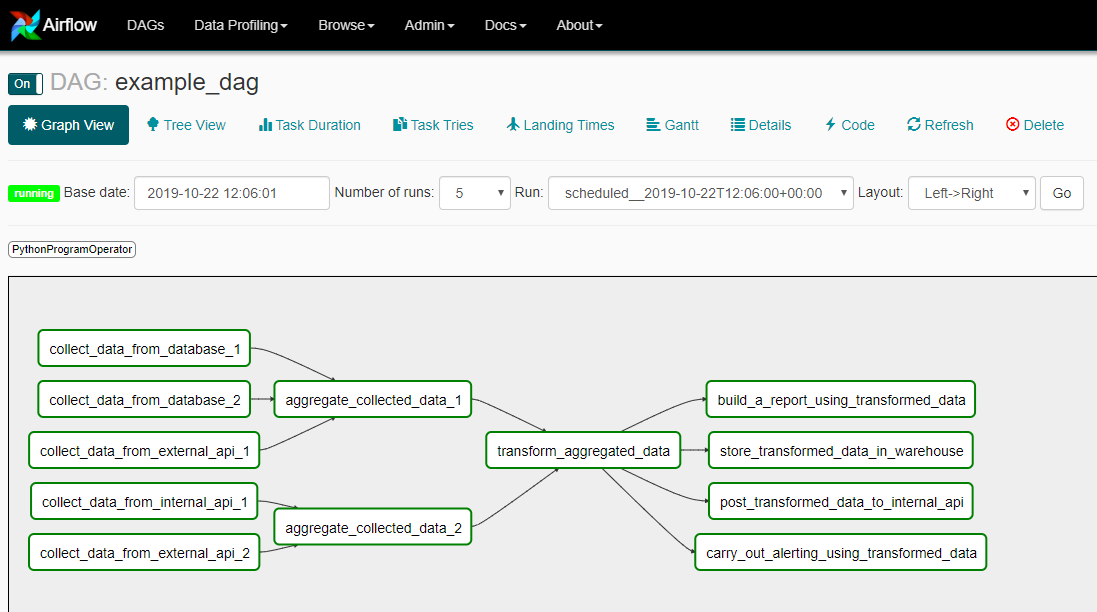

In [8]:
from IPython.display import Image
Image("airflow_workflow.png", width=600, height=600)

### Kubeflow example

In [ ]:
import kfp.compiler as compiler
import kfp.dsl as dsl
import kfp.gcp as gcp
import kfp.onprem as onprem

platform = 'GCP'

@dsl.pipeline(
  name='MNIST',
  description='A pipeline to train and serve the MNIST example.'
)
def mnist_pipeline(model_export_dir='gs://your-bucket/export',
                   train_steps='200',
                   learning_rate='0.01',
                   batch_size='100',
                   pvc_name=''):
  """
  Pipeline with three stages:
    1. train an MNIST classifier
    2. deploy a tf-serving instance to the cluster
    3. deploy a web-ui to interact with it
  """
  train = dsl.ContainerOp(
      name='train',
      image='gcr.io/kubeflow-examples/mnist/model:v20190304-v0.2-176-g15d997b',
      arguments=[
          "/opt/model.py",
          "--tf-export-dir", model_export_dir,
          "--tf-train-steps", train_steps,
          "--tf-batch-size", batch_size,
          "--tf-learning-rate", learning_rate
          ]
  )

  serve_args = [
      '--model-export-path', model_export_dir,
      '--server-name', "mnist-service"
  ]
  if platform != 'GCP':
    serve_args.extend([
        '--cluster-name', "mnist-pipeline",
        '--pvc-name', pvc_name
    ])

  serve = dsl.ContainerOp(
      name='serve',
      image='gcr.io/ml-pipeline/ml-pipeline-kubeflow-deployer:'
            '7775692adf28d6f79098e76e839986c9ee55dd61',
      arguments=serve_args
  )
  serve.after(train)


  webui_args = [
          '--image', 'gcr.io/kubeflow-examples/mnist/web-ui:'
                     'v20190304-v0.2-176-g15d997b-pipelines',
          '--name', 'web-ui',
          '--container-port', '5000',
          '--service-port', '80',
          '--service-type', "LoadBalancer"
  ]
  if platform != 'GCP':
    webui_args.extend([
      '--cluster-name', "mnist-pipeline"
    ])

  web_ui = dsl.ContainerOp(
      name='web-ui',
      image='gcr.io/kubeflow-examples/mnist/deploy-service:latest',
      arguments=webui_args
  )
  web_ui.after(serve)

  steps = [train, serve, web_ui]
  for step in steps:
    if platform == 'GCP':
      step.apply(gcp.use_gcp_secret('user-gcp-sa'))
    else:
      step.apply(onprem.mount_pvc(pvc_name, 'local-storage', '/mnt'))

compiler.Compiler().compile(mnist_pipeline, __file__ + '.tar.gz')


### Airflow example

In [ ]:
from airflow.operators.valohai import ValohaiSubmitExecutionOperator

train = ValohaiSubmitExecutionOperator(
  task_id='train_model',
  # Specify the project and step from Valohai
  project_name='tensorflow-example',
  step='Train model (MNIST)',
  # Override defaults
  environment='aws-eu-west-1-g3-4xlarge',
  inputs={
    'training-set-images': ValohaiSubmitExecutionOperator.get_output_uri(
      task=preprocess,
      name='mnist-train-images.gz'),
    'training-set-labels': ValohaiSubmitExecutionOperator.get_output_uri(
      task=preprocess,
      name='mnist-train-labels.gz'),
    'test-set-images': ValohaiSubmitExecutionOperator.get_output_uri(
      task=preprocess,
      name='mnist-test-images.gz'),
    'test-set-labels': ValohaiSubmitExecutionOperator.get_output_uri(
      task=preprocess,
      name='mnist-test-labels.gz'),
  },
  parameters={
    'dropout': 0.9,
    'learning_rate': 0.001,
    'max_steps': 300,
    'batch_size': 200,
  },
  # Associate a task to a previously created DAG
  dag=dag,
)

# Set dependencies between tasks
preprocess >> train

# Autodeploy

Goal: Lightweight scalable library for ML model management focus on degradation performance.

" Data scientists are adopting containers to improve their workflows by realizing benefits such as packaging of dependencies and creating reproducible artifacts. "

" Far too often have these two roles operated without enough consideration for one another despite the fact that they occupy the same space. “That’s not my job” is not the right approach. To produce something that is reliable, sustainable, and adaptable, both roles must work together more effectively. ". Byron Allen



Pros
- Ease of use, fast prototyping.
- Nested and parallel workflows execution.
- Post-modeling checking, unsupervised checkers (e.g, draft distributions).
- Orchestator-agnostic.
- Version control.
- Based on MLflow.

Cons
- Not scheduling metadata.
- Not so mature yet.

## Example

- Nested and parallel workflows allow to create complex topologies dynamically. 
- Each workflow has an isolated tracker and network.
- Each workflow might have a checker. This component will check the sanity, integrity, and even behaviour for inputs and outputs.

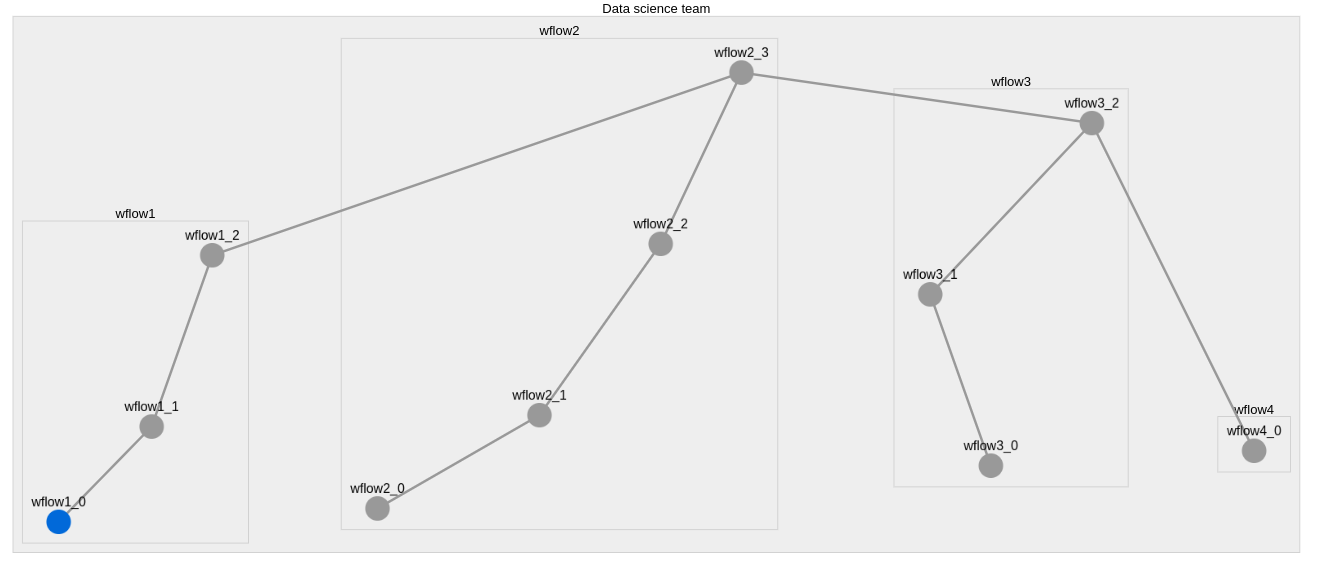

In [5]:
from IPython.display import Image
Image("ad_workflow.png", width=600, height=600)

In [ ]:
# This workflow1 will gather and preprocess the raw data set. Order matters.
workflow1 = [
    {'name': 'gathering', 
     'file': 'gathering.py', 
     'parameters': {'raw_data_path': 'leaf.csv',
                    'percentage': 1.0},
     'dockerfile': 'Dockerfile_gathering'}, # Provides a dockerfile
    
    {'name': 'preprocessing',
     'file': 'preprocessing.py', 
     'requirements': 'req_preprocessing.txt'}, # Convert requirements.txt to dockerfile

]

# This workflow2 will model preprocess data set in parallel. 
workflow2 = [
    {'name': 'modeling',
     'file': 'modeling.py', 
     'parameters': {'preprocessed_data': 'preprocessed_data.csv',
                    'model_path': 'models',
                    'n_estimators': 10},
     'requirements': 'req_modeling.txt'}, # Convert requirements.txt to dockerfile
    {'name': 'modeling2',
     'file': 'modeling.py', 
     'parameters': {'preprocessed_data': 'preprocessed_data.csv',
                    'model_path': 'models2',
                    'n_estimators': 20},
     'requirements': 'req_modeling.txt'},
    
]

workflows = [
    {'name': 'workflow1', 'workflow': workflow1, 
     'tracker': {'port': 8001}},
    {'name': 'workflow2', 'workflow': workflow2, 
     'tracker': {'port': 8002}, 'parallel': True}
   
]

# Conclusion

- Pre-deployment (steps required for getting a model): MLflow, Autodeploy
- Deployment (put a model into production): MLflow, Autodeploy, Kubeflow
- **Post-Deployment (check the model's health): Autodeploy**
- **Ease of use: Autodeploy > MLflow > Kubeflow**.
- Ease of installation: MLflow (pip) > Autodeploy (pip, docker) > Kubeflow (docker, kubernetes)
- Everyone provides an experiment tracking.
- Everyone provides a model versioning.
- Dynamic execution of workflows (change the execution behaviour at running time): Autodeploy, Kubeflow, Airflow.
- Parallel execution of workflows (run more than 1 step at the same time): Autodeploy, Kubeflow, Airflow.
- **Orchestation-agnostic (export integration config files): Autodeploy (swarm, compose, kubernetes).**
